In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import signal
from tools import *

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread

# Import auryn tools
sys.path.append(os.path.expanduser("~/auryn/tools/python/"))
from auryntools import *
from matplotlib import animation, rc
from IPython.display import HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import tools
import elephant
import quantities as pq
from neo.core import SpikeTrain
import viziphant
from pyvis.network import Network


In [2]:
dure_simu = 7200
begining_presentation = 3600
duree_pattern = 0.1
time_step = 0.01
auryn_tstep = 0.0001
spls = dure_simu/time_step

In [3]:
deb = 7150
dur = 3
beg = int(deb//time_step)
end = beg+int(dur//time_step)

In [4]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("~/data/sim_network/sim_First_sim_pattern") # Set this to your data path
prefix = "rf1"

nb_neurons = 4096
nb_stim = 4
time_range = 400
bin_size = 100e-3

In [5]:
signal_times = np.genfromtxt(datadir+'/pattern_time_readable', delimiter=' ')
signal = np.zeros(int(dure_simu//time_step)+1)
for time in signal_times:
    signal[int(time//time_step):int((time//time_step)+(duree_pattern//time_step))]=1

# Find low rank structure in spiking activity

In [6]:
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)


In [7]:
rateE  = np.mean([np.loadtxt("%s/%s.%i.e.prate"%(datadir,prefix,i)) for i in range(num_mpi_ranks)],axis=0)

KeyboardInterrupt: 

In [ ]:
time_axis = rateE[:,0]
rateE= rateE[:,1]

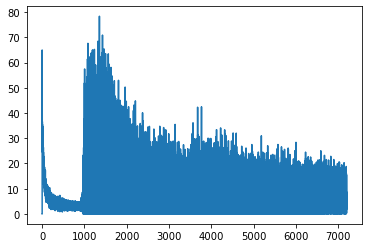

In [9]:
plt.plot(time_axis,rateE)

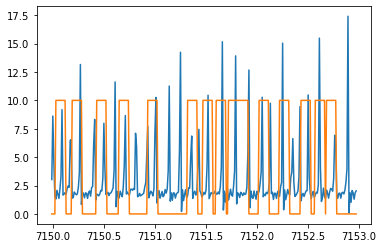

In [10]:
plt.plot(time_axis[beg:end],rateE[beg:end])
plt.plot(time_axis[beg:end],signal[beg:end]*10)

In [11]:
rateI  = np.mean([np.loadtxt("%s/%s.%i.i2.prate"%(datadir,prefix,i)) for i in range(num_mpi_ranks)],axis=0)
time_axis_I = rateI[:,0]
rateI= rateI[:,1]

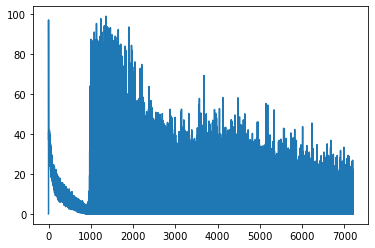

In [12]:
plt.plot(time_axis_I,rateI)

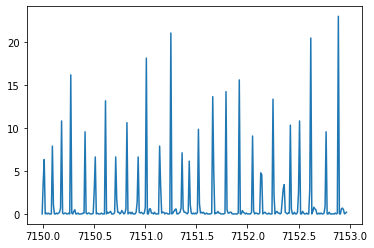

In [13]:
plt.plot(time_axis_I[beg:end],rateI[beg:end])

## Etudes du suivi du pattern

In [9]:
spikes = np.array(sfo.get_spikes(t_start=7100))

In [10]:
times,dists = tools.SpikesDistFromPat(spikes[:,0],duree_pattern,signal_times)

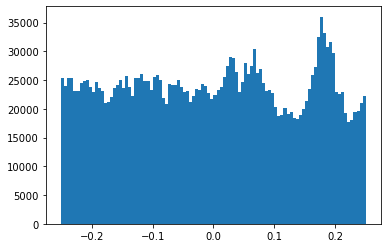

In [11]:
plt.hist(dists,bins=100);

In [18]:
distance_per_neurones = np.array(list(zip(dists,spikes[:,1])))

In [19]:
ListTrains_distance = [[] for _ in range(nb_neurons)]
for spike in range(len(distance_per_neurones)):
    ListTrains_distance[int(distance_per_neurones[:, 1][spike])].append(distance_per_neurones[:, 0][spike])

In [20]:
ListTrains = [[] for _ in range(nb_neurons)]
for spike in range(len(spikes)):
    ListTrains[int(spikes[:, 1][spike])].append(spikes[:, 0][spike])

In [21]:
scores = np.array(list(map( lambda x: np.sum(np.array(x)<duree_pattern)/len(x) ,ListTrains_distance)))

<ipython-input-21-e1778023f355>:1: RuntimeWarning: invalid value encountered in long_scalars
  scores = np.array(list(map( lambda x: np.sum(np.array(x)<duree_pattern)/len(x) ,ListTrains_distance)))


### Certains neurones sont hyper actifs.

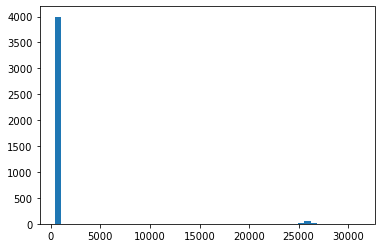

In [22]:
plt.hist(list(map(len,ListTrains)),bins=50);

### Une minorité code bien le signal

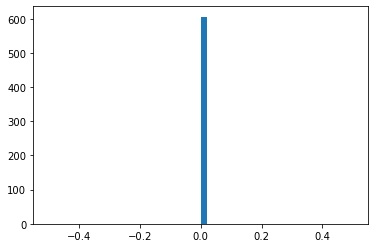

In [23]:
plt.hist(scores,bins=50);

In [24]:
not_to_fast_ones  = [ListTrains[li]  for li in range(len(ListTrains)) if len(ListTrains[li])<10000]

### Deux population distinctes en terme de firing rate ?

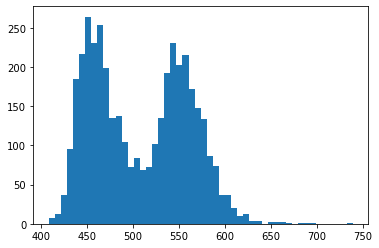

In [25]:
plt.hist(list(map(len,not_to_fast_ones)),bins=50);

### Un neuron parfait ?

In [26]:
the_one = np.argmax(scores)

### Et qui fire assez souvent. Si sont firing rate était à la ramasse, on aurait pu penser 
### qu'il se serait fait attribué un bon score par accident.

In [27]:
lelu = SpikeTrain(ListTrains[the_one]*pq.s,t_start=min(ListTrains[the_one]),t_stop=max(ListTrains[the_one]))
len(ListTrains[the_one])

459

In [28]:
times_one ,dists_one = tools.SpikesDistFromPat(ListTrains[the_one],duree_pattern,signal_times)

### On remarque encore une fois les deux modes d'encodage 

In [17]:
plt.scatter(times_one,dists_one)

NameError: name 'times_one' is not defined

### Des bons neurones 

In [18]:
the_ones = np.where(scores>0.80)[0]

NameError: name 'scores' is not defined

In [82]:
scatter_ones = np.sort([spike  for  n in the_ones for spike in ListTrains[n]])

In [83]:
times_ones ,dists_ones = tools.SpikesDistFromPat(scatter_ones,duree_pattern,signal_times)

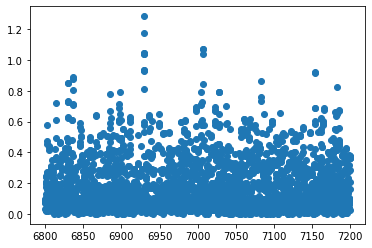

In [84]:
plt.scatter(times_ones,dists_ones)

### Codage négatif, Possible competition

In [85]:
wrong_one = np.argmin(scores)

In [86]:
times_wrong ,dists_wrong = tools.SpikesDistFromPat(ListTrains[wrong_one],duree_pattern,signal_times)

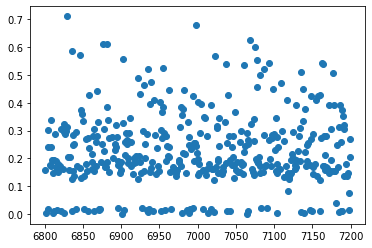

In [87]:
plt.scatter(times_wrong,dists_wrong)

## Etude de la matrice de connectivité

In [103]:
wmatfiles  = ["%s/rf1.%i.ee.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
w = np.sum( [ mmread(wf) for wf in wmatfiles ] )

In [104]:
the_ones

array([  42, 1030, 1359, 1381, 1561, 1631, 1855, 1863, 1906, 1999, 2047,
       2313, 2498, 2647, 2910, 2974, 2985, 2999, 3147, 3449, 3480, 3743,
       3790, 3857, 3880, 3944])

# Load and analyze EE weights

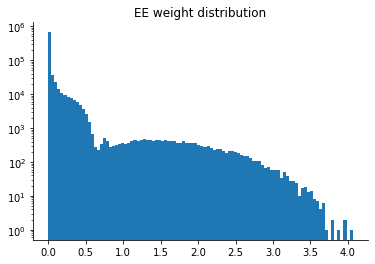

In [105]:
h1 = plt.hist(w.data, bins=100, log=True)
plt.title("EE weight distribution")
sns.despine()

In [90]:
connectivity_pat =[]
for n in the_ones:
    for n2 in the_ones:
        if w[n,n2]>0:
            connectivity_pat.append([n,n2,w[n,n2]])
connectivity_pat = np.array(connectivity_pat)   

In [92]:
most_connected_arg = connectivity_pat[connectivity_pat[:,2].argsort()[-60:][::-1]]
most_connected= most_connected_arg[:,[0,1]].ravel().astype(int)
scores_mst =scores[most_connected]

In [95]:
net = Network(notebook=True)
net.add_nodes(most_connected)
net.add_edges(most_connected_arg)

In [97]:
 net.show("my_network.html")